In [1]:
%matplotlib inline

# car2go data analysis and exploration

This notebook investigates the consistency and key features of the available car2go data sets.

Created on:  2016-09-20  
Last update: 2016-09-26  
Contact: michael.szell@moovel.com, michael.szell@gmail.com (Michael Szell)

## General information about the car2go service

*Reservations*  
Cars can be reserved up to 30 minutes in advance. Reserved cars are removed from the map and are invisible to crawlers. Anecdotal knowledge: Reservations up to 20 minutes usually lead to a trip, longer reservations not. It is not clear how long the average reservation time is.

*Trips*  
Trips can last up to 48 hours, but potentially also longer: car2go behält sich das Recht vor, Einzelmietverträge jederzeit einseitig zu beenden, wenn diese die maximale Mietzeit von 48 Stunden überschreiten.

*Parking*  
During a trip, a car can be parked. This reduces the running cost from 0.29 EUR to 0.19 EUR / min. Parked cars are part of the rental time and therefore not visible to crawlers. 

## Crawled car2go data (2015-2016)
Data crawled by https://github.com/moovel/moovel-predict

The crawl pings happened every 1 min until 2015-10-12,  
from then every 10 min until 2016-05-23 13:04,  
from then every 5 min

In [58]:
# preliminaries
import sys
import csv
import os
import math
import pprint
import requests
import gzip
from collections import defaultdict
import time
import datetime
import numpy as np
from scipy import stats
import pyprind
import itertools
import logging
from ast import literal_eval as make_tuple

# plotting stuff
import matplotlib.pyplot as plt
# import mpld3
# mpld3.enable_notebook() # unfortunately, this is too buggy: https://github.com/mpld3/mpld3/issues/193
# mpld3.disable_notebook()

pathdatain = '/Users/szellmi/Google Drive/MOOVELLAB/00_Projects/mobviz/data/raw/'
pathdataout = '/Users/szellmi/Google Drive/MOOVELLAB/00_Projects/mobviz/data/derived/'
pathdatainlocal = '/Users/szellmi/mobviz/raphael/aa_root/'
pathdataoutlocal = '/Users/szellmi/mobviz/data/derived/'
curtime = time.strftime("%Y%m%d_%H%M%S")
logging.basicConfig(filename=pathdataout+'mobviz_dataanalysis'+curtime+'.log',level=logging.DEBUG)
pp = pprint.PrettyPrinter(indent=4)

flag_calculate = True # if this flag is set, data will be calculated, not loaded
# Until importcartimelines is adapted to work with the crawled car2go data, always set this to True

In [3]:
# functions

def writedictlists(filepath, dictlists, mode='w'):
    with open(filepath, mode) as f:
        keyssorted = sorted(list(dictlists.keys()))
        for j, k in enumerate(keyssorted):
            f.write(','.join([str(i) for i in dictlists[k]]))
            if j != len(dictlists)-1: # no linebreak after last line
                f.write("\n")
                
def writedictkeys(filepath, dictlists, mode='w'):
    with open(filepath, mode) as f:
        keyssorted = sorted(list(dictlists.keys()))
        for j, k in enumerate(keyssorted):
            f.write(str(k))
            if j != len(dictlists)-1: # no linebreak after last line
                f.write("\n")

def importcartimelines(filepath): # Use this only for car2go direct data, not (yet) for the crawled one
    tempfilepath = filepath[0:-4]+'id'+filepath[-4:]
    keys = [line.rstrip('\n') for line in open(tempfilepath)]
    return {'cartimelinesopstatebefore': readdictlists(filepath[0:-4]+'opstatebefore'+filepath[-4:], keys),
            'cartimelinesopstateafter': readdictlists(filepath[0:-4]+'opstateafter'+filepath[-4:], keys),
            'cartimelines': readdictlists(filepath, keys),
            'cartimelinesid': keys,
            'cartimelinesdiff': readdictlists(filepath[0:-4]+'diff'+filepath[-4:], keys),
            'cartimelinesparking': readdictlists(filepath[0:-4]+'parking'+filepath[-4:], keys),
            'cartimelinesloc': readdictlistsloc(filepath[0:-4]+'loc'+filepath[-4:], keys),
            'cardailymovedurations': readdictlists(filepath[0:-13]+'dailymovedurations'+filepath[-4:], keys)
           }

def readdictlists(filepath, keys):
    output = {}
    keys = sorted(list(keys))
    with open(filepath, 'r') as f:
        for i, line in enumerate(f):
            try:
                output[keys[i]] = [int(x) for x in line.rstrip('\n').split(',')]
            except: # if it is just one element
                output[keys[i]] = [int(x) for x in line.rstrip('\n')]
    return output

def readdictlistsloc(filepath, keys):
    output = {}
    keys = sorted(list(keys))
    with open(filepath, 'r') as f:
        for i, line in enumerate(f):
            output[keys[i]] = [make_tuple(x.strip("()")) for x in line.rstrip('\n').split('),(')] # http://stackoverflow.com/questions/9763116/parse-a-tuple-from-a-string. make_tuple is maybe the most elegant way, but makes it really slow. if speed needed, change this.
    return output
                
def createdailymovedurations(cartimelines, timefirst=1383346800, timelast=1414882800, cartimelinesopstate = {}):
    # From car timelines (durations of single trips), generate sums of trips aggregated daily. This includes parking times.
    bar = pyprind.ProgBar(len(cartimelines), bar_char='█', update_interval=1)
    cardailymovedurations = defaultdict(list)
    # go through days for all cars
    flag_carinuse = True
    for k in cartimelines:
        thiscartimeline = np.array(cartimelines[k])
        thiscartimelinediff = np.array(cartimelinesdiff[k])
        if len(cartimelinesopstate) == len(cartimelines): # we have opstate info, so consider it
            thiscartimelineopstate = np.array(cartimelinesopstate[k])
        for d in list(range(timefirst, timelast, 86400)):
            ind = np.where(np.logical_and(thiscartimeline >= d, thiscartimeline < d+86400))
            thisdaymovedurations = np.sum(thiscartimelinediff[ind[0][:-1]])
            if thisdaymovedurations == 0 and not(flag_carinuse):
                thisdaymovedurations = -1
            if thisdaymovedurations > 0: # There was movement, so car is in use again
                flag_carinuse = True
            cardailymovedurations[k].append(thisdaymovedurations)
            if len(cartimelinesopstate) == len(cartimelines): # we have opstate info, so consider it
                if 0 in thiscartimelineopstate[ind[0][:-1]]:
                    flag_carinuse = False # if there is a zero opstate, set Flag to False so that following zero-days do not count
        bar.update(item_id = i)
        
    # another loop to set all 0,0,0,|0,0,.. to 0,0,0,|-1,-1,.. because cars have to be removed after not used in 72 hours
    for k in cardailymovedurations:
        zerocounter = 0
        thiscardailymovedurations = cardailymovedurations[k]
        for j in range(len(thiscardailymovedurations)):
            if thiscardailymovedurations[j] == 0:
                zerocounter += 1
            else:
                zerocounter = 0
            if zerocounter > 3:
                thiscardailymovedurations[j] = -1
        cardailymovedurations[k] = thiscardailymovedurations
    return cardailymovedurations

def file_len(fname): # http://stackoverflow.com/questions/845058/how-to-get-line-count-cheaply-in-python
    with open(fname) as f:
        for i, l in enumerate(f):
            pass
    return i + 1

def isgoodopstate(opstate):
    if opstate == "GREEN" or opstate == "ORANGE" or opstate == "RED":
        return True
    else:
        return False
    
def mapopstate(opstate):
    # opstates:
    # GREEN: free
    # ORANGE: reserved
    # RED: occupied
    # else: service
    if opstate == "GREEN" or opstate == "RED":
        return 1
    elif opstate == "ORANGE":
        return 2
    else:
        return 0

In [ ]:
# create a dict of car timelines, storing all points in time when the car was available
chunklimits = [0]+list(range(5000000, 51000001, 2000000))
limitstrout = str(chunklimits[0]+1)+'-'+str(chunklimits[-1])
    
if flag_calculate:
    # Go through the chunks
    cartimelines = defaultdict(list)
    cartimelinesdiff = defaultdict(list)
    cartimelinesloc = defaultdict(list)
    for c in range(len(chunklimits)-1):
        indlow = chunklimits[c]+1
        indhigh = chunklimits[c+1]
        limitstr = str(indlow)+'-'+str(indhigh)
        datain = 'car2go_crawl_'+limitstr+'.csv' # 'testData_moovelCrawler.csv'

        # UNIX timestamps and locations
        bar = pyprind.ProgBar(file_len(pathdatain+datain), bar_char='█', update_interval=1)
        with open(pathdatain+datain, 'r') as f:
            reader = csv.reader(f)
            for i, line in enumerate(reader):
                bar.update(item_id = [i, limitstr])
                if i >= 1: # ignore header
                    s = str(line[3]) + "/" + str(line[4]) + "/" + str(line[5]) + "/" + str(line[6]) + "/" + str(line[7])
                    try:
                        timestamp = int(time.mktime(datetime.datetime.strptime(s, "%Y/%m/%d/%H/%M").timetuple()))
                        if timestamp > 1444644180: # before 1444644180, crawler was running every minute. after, every 10 minutes.
                            cartimelines[line[0]].append(timestamp)
                            cartimelinesloc[line[0]].append((line[1], line[2])) # lat,lng
                    except: # There is June 31st for some reason..
                        logging.error("Date not defined: "+s)
                        pass
    # export
    dataout = 'car2go_crawl_'+limitstrout+'_cartimelinesid.txt'
    writedictkeys(pathdataout+dataout, cartimelines)

    dataout = 'car2go_crawl_'+limitstrout+'_cartimelines.txt'
    writedictlists(pathdataout+dataout, cartimelines)

    dataout = 'car2go_crawl_'+limitstrout+'_cartimelinesloc.txt'
    writedictlists(pathdataout+dataout, cartimelinesloc)

    # create diffs
    for k in cartimelines:
        thistimediffsall = list(np.diff(np.asarray(cartimelines[k])))
        thistimediffs = []
        thistimelinesall = cartimelines[k]
        for i, d in enumerate(thistimediffsall):
            if cartimelines[k][i] < 1464005100: # 2016-05-23 13:04, had 10 min ping diffs
                if d > 660 or (d <= 660 and cartimelinesloc[k][i] != cartimelinesloc[k][i+1]): # if timediff is small, record only if location has changed
                    thistimediffs.append(int(d//60)) # divide by 60 to see minutes, not seconds
                else:
                    thistimediffs.append(0) # add zero so we know there was no movement
            else: 
                if d > 360 or (d <= 360 and cartimelinesloc[k][i] != cartimelinesloc[k][i+1]): # if timediff is small, record only if location has changed
                    thistimediffs.append(int(d//60)) # divide by 60 to see minutes, not seconds
                else:
                    thistimediffs.append(0) # add zero so we know there was no movement
        cartimelinesdiff[k] = thistimediffs

    # export
    dataout = 'car2go_crawl_'+limitstrout+'_cartimelinesdiff.txt'
    writedictlists(pathdataout+dataout, cartimelinesdiff)
    
    # Daily use: for each car, look how much it is moved every day
    cardailymovedurations = createdailymovedurations(cartimelines, 1444690800, 1474498800)
    # 1444690800 = 2015-10-13 00:00:00 CET
    # 1474498800 = 2016-09-22 00:00:00 CET

    # export
    dataout = 'car2go_crawl_'+limitstrout+'_cardailymovedurations.txt'
    writedictlists(pathdataout+dataout, cardailymovedurations)
    
else:
    # load data
    cartimelinesinfo = importcartimelines(pathdataout+'car2go_crawl_'+limitstrout+'_cartimelines.txt')
    cartimelines = cartimelinesinfo['cartimelines']
    cartimelinesid = cartimelinesinfo['cartimelinesid']
    cartimelinesdiff = cartimelinesinfo['cartimelinesdiff']
    cartimelinesloc = cartimelinesinfo['cartimelinesloc']

In [ ]:
# check file lengths
# for c in range(len(chunklimits)-1):
#     indlow = chunklimits[c]+1
#     indhigh = chunklimits[c+1]
#     limitstr = str(indlow)+'-'+str(indhigh)
#     datain = 'car2go_crawl_'+limitstr+'.csv' # 'testData_moovelCrawler.csv'
#     print(limitstr+': '+str(file_len(pathdatain+datain)))

# consistency checks
# plot the times. go through all hours and plot number of car records

times = range(1444644780, 1472199840, 24*3600)
numrecs = [0]*(len(times)-1)
for k in cartimelines:
    x = np.array(cartimelines[k])
    for i in range(len(times)-1):
        indlow = times[i]
        indhigh = times[i+1]
        numrecs[i] += np.count_nonzero(np.where(np.logical_and( x >= indlow, x < indhigh)))
    

In [ ]:
# plot
x = np.array(list(times[:-1]))
y = np.array(numrecs)
plt.figure(figsize=(12,5))
plt.ylabel('Number of daily records')
plt.xlabel('Timestamp')
plt.title('car2go crawled: Data availability')
xticks = list(range(1440000000, 1480000000, 5000000))
labels = [datetime.datetime.fromtimestamp(t).strftime('%Y-%m-%d') for t in xticks]
plt.xticks(xticks, labels)
plt.plot(x, y);

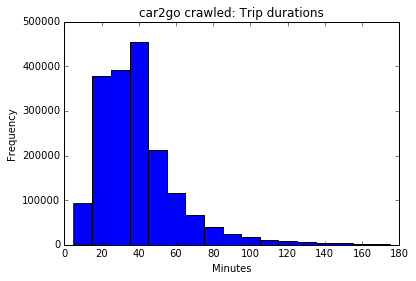

In [30]:
# Histogram of trip durations
diffs = [cartimelinesdiff[k] for k in cartimelinesdiff]
data = np.hstack(diffs)
plt.hist(data, bins=list(range(5,180,10)))
plt.ylabel('Frequency')
plt.xlabel('Minutes')
plt.title('car2go crawled: Trip durations')
plt.show()

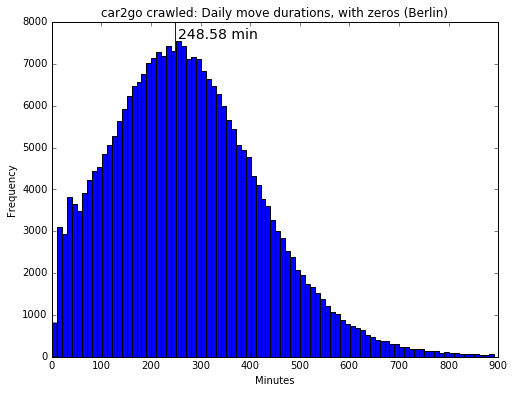

In [31]:
# Histogram of daily move durations
cityname = 'Berlin'
data = [cardailymovedurations[k] for k in cardailymovedurations]
data = list(itertools.chain(*data))
#data = np.divide(np.asarray(data), 60)
data = np.asarray(data)
data = data[data>=0] # do not consider the -1 values
plt.figure(figsize=(8,6))
plt.hist(data, bins=list(range(1,900,10)))
plt.text(np.mean(data) + 6, 7600, str(round(np.mean(data), 2))+" min", fontsize=14)
plt.axvline(x=np.mean(data))
plt.ylabel('Frequency')
plt.xlabel('Minutes')
plt.title('car2go crawled: Daily move durations, with zeros ('+cityname+')')
plt.show()

## Crawled MyTaxi data

In [ ]:
# # create a dict of taxi timelines, storing all points in time when the car was available
# # NOTE: The IDs are not unique / do not make sense. The output from here is garbage.
# datain = 'myTaxi_entireCrawl.csv'

# # UNIX timestamps and locations
# cartimelines = defaultdict(list)
# cartimelinesdiff = defaultdict(list)
# cartimelinesloc = defaultdict(list)
# bar = pyprind.ProgBar(file_len(pathdatain+datain), bar_char='█', update_interval=1)
# with open(pathdatain+datain, 'r') as f:
#     reader = csv.reader(f)
#     for i, line in enumerate(reader):
#         bar.update(item_id = i)
#         if i >= 1: # ignore header
#             s = str(line[3]) + "/" + str(line[4]) + "/" + str(line[5]) + "/" + str(line[6]) + "/" + str(line[7])
#             try:
#                 timestamp = int(time.mktime(datetime.datetime.strptime(s, "%Y/%m/%d/%H/%M").timetuple()))
#                 cartimelines[line[0]].append(timestamp)
#                 cartimelinesloc[line[0]].append((line[1], line[2])) # lat,lng
#             except: # There is June 31st for some reason..
#                 pass
            
# # export
# dataout = 'mytaxi_crawl_cartimelinesid.txt'
# writedictkeys(pathdataout+dataout, cartimelines)
        
# dataout = 'mytaxi_crawl_cartimelines.txt'
# writedictlists(pathdataout+dataout, cartimelines)

# dataout = 'mytaxi_crawl_cartimelinesloc.txt'
# writedictlists(pathdataout+dataout, cartimelinesloc)
        
# # create diffs
# for k in cartimelines:
#     thistimediffsall = list(np.diff(np.asarray(cartimelines[k])))
#     thistimediffs = []
#     for i, d in enumerate(thistimediffsall):
#         #if d > 600 or (d == 600 and cartimelinesloc[k][i] != cartimelinesloc[k][i+1]): # if timediff is 600, record only if location has changed
#         thistimediffs.append(d//60) # divide by 60 to see minutes, not seconds
#         #else:
#         #    thistimediffs.append(0) # add zero so we know there was no movement
#     cartimelinesdiff[k] = thistimediffs
    
# # export
# dataout = 'mytaxi_crawl_cartimelinesdiff.txt'
# writedictlists(pathdataout+dataout, cartimelinesdiff)

## Direct car2go data (2014)

This is sensitive data gathered by Raphael Reimann directly from car2go that cannot be shared or made public.

In [ ]:
# create a dict of car timelines, storing all points in time when the car was available
citynames = ['Berlin', 'Düsseldorf', 'Hamburg', 'Köln', 'München', 'Stuttgart', 'Ulm', 'Wien']

for cityname in citynames:
    datain = 'Rentals_'+cityname+'.csv'

    # UNIX timestamps and locations
    cartimelines = defaultdict(list)
    cartimelinesdiff = defaultdict(list)
    cartimelinesparking = defaultdict(list)
    cartimelinesloc = defaultdict(list)
    cartimelinesopstateafter = defaultdict(list)
    cartimelinesopstatebefore = defaultdict(list)
    bar = pyprind.ProgBar(file_len(pathdatainlocal+datain), bar_char='█', update_interval=1)
    with open(pathdatainlocal+datain, 'r') as f:
        reader = csv.reader(f, delimiter=";")
        for i, line in enumerate(reader):
            vehicleid = line[3] # VEHICLE_VIN
            bar.update(item_id = i)
            if i >= 1: # ignore header
                s = str(line[4][:19]) # STARTED_LOCAL
                timestamp = int(time.mktime(datetime.datetime.strptime(s, "%Y-%m-%d %H:%M:%S").timetuple()))
                if int(line[15]) == 0 and int(line[12]) > 0 and int(line[12]) > int(line[13]):
                    # only non-service-drives, non-1900 drives where duration is 0, and drives where car was actually moved
                    cartimelines[vehicleid].append(timestamp)
                    cartimelinesloc[vehicleid].append((float(line[5].replace(',', '.')), float(line[6].replace(',', '.')))) # lat,lng
                    cartimelinesdiff[vehicleid].append(int(line[12])) # DURATION
                    cartimelinesparking[vehicleid].append(int(line[13])) # PARKINGDURATION
                    cartimelinesopstateafter[vehicleid].append(mapopstate(line[-1])) # OPSTATE_AFTER
                    cartimelinesopstatebefore[vehicleid].append(mapopstate(line[-2])) # OPSTATE_BEFORE

    # export
    dataout = 'car2go_direct2014_'+cityname+'_cartimelinesid.txt'
    writedictkeys(pathdataoutlocal+dataout, cartimelines)

    dataout = 'car2go_direct2014_'+cityname+'_cartimelines.txt'
    writedictlists(pathdataoutlocal+dataout, cartimelines)

    dataout = 'car2go_direct2014_'+cityname+'_cartimelinesloc.txt'
    writedictlists(pathdataoutlocal+dataout, cartimelinesloc)

    dataout = 'car2go_direct2014_'+cityname+'_cartimelinesdiff.txt'
    writedictlists(pathdataoutlocal+dataout, cartimelinesdiff)
    
    dataout = 'car2go_direct2014_'+cityname+'_cartimelinesparking.txt'
    writedictlists(pathdataoutlocal+dataout, cartimelinesparking)

    dataout = 'car2go_direct2014_'+cityname+'_cartimelinesopstatebefore.txt'
    writedictlists(pathdataoutlocal+dataout, cartimelinesopstatebefore)

    dataout = 'car2go_direct2014_'+cityname+'_cartimelinesopstateafter.txt'
    writedictlists(pathdataoutlocal+dataout, cartimelinesopstateafter)

    # Daily use: for each car, look how much it is moved every day
    cardailymovedurations = createdailymovedurations(cartimelines, 1383346800, 1414882800, cartimelinesopstateafter)
    # 1383346800 = 2013-11-02 00:00:00 CET
    # 1414882800 = 2014-11-01 00:00:00 CET
    # export
    dataout = 'car2go_direct2014_'+cityname+'_cardailymovedurations.txt'
    writedictlists(pathdataoutlocal+dataout, cardailymovedurations)

In [8]:
# data was just saved. now load it.
cityname = 'Berlin'
cartimelinesinfo = importcartimelines(pathdataoutlocal+'car2go_direct2014_'+cityname+'_cartimelines.txt')
cartimelines = cartimelinesinfo['cartimelines']
cartimelinesid = cartimelinesinfo['cartimelinesid']
cartimelinesdiff = cartimelinesinfo['cartimelinesdiff']
cartimelinesopstateafter = cartimelinesinfo['cartimelinesopstateafter']
cartimelinesopstatebefore = cartimelinesinfo['cartimelinesopstatebefore']
cartimelinesloc = cartimelinesinfo['cartimelinesloc']
cartimelinesparking = cartimelinesinfo['cartimelinesparking']
cardailymovedurations = cartimelinesinfo['cardailymovedurations']

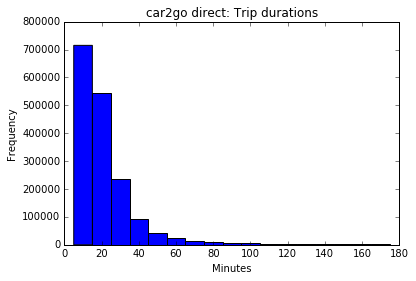

In [6]:
# Histogram of trip durations
diffs = [cartimelinesdiff[k] for k in cartimelinesdiff]
data = np.hstack(diffs)
data = np.divide(np.asarray(data), 60)
plt.hist(data, bins=list(range(10-5,180,10)))
plt.ylabel('Frequency')
plt.xlabel('Minutes')
plt.title('car2go direct: Trip durations')
plt.show()

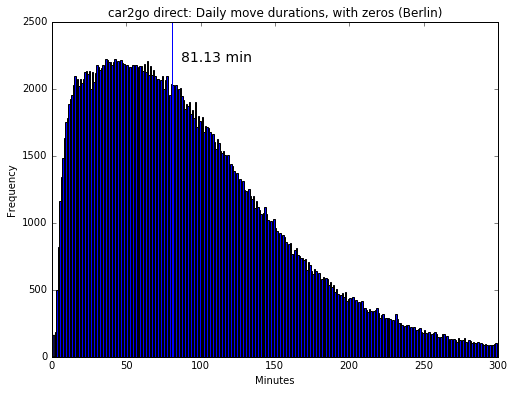

In [10]:
# Histogram of daily move durations
data = [cardailymovedurations[k] for k in cardailymovedurations]
data = list(itertools.chain(*data))
data = np.divide(np.asarray(data), 60)
data = data[data>=0] # do not consider the -1 values
plt.figure(figsize=(8,6))
plt.hist(data, bins=list(range(1,300,1)))
plt.text(np.mean(data) + 6, 2200, str(round(np.mean(data), 2))+" min", fontsize=14)
plt.axvline(x=np.mean(data))
plt.ylabel('Frequency')
plt.xlabel('Minutes')
plt.title('car2go direct: Daily move durations, with zeros ('+cityname+')')
plt.show()

In [ ]:
# boxplot
# turns out data is too skewed for a reasonable box plot
#fig = plt.figure(figsize=(8,6))
#plt.boxplot(data, 0, 'rs', 0)
#plt.yticks([1])
#plt.ylabel('measurement x')
#plt.title('Daily move durations, all zeros removed ('+cityname+')')
#plt.show()

## Making sense of the discrepancy between crawled and direct car2go data

We observe the following: Trip durations of crawled data are substantially inflated, by about 25 minutes. As a consequence, daily move durations are also inflated. The question is why?

Possible explanations, ordered by expected impact of effect:
* Reservations take out a car from the crawler prior to the real trip, increase trip duration as perceived by crawling
* Two trips that follow up shortly on each other are concatenated as one long trip if no ping happens between them. This should have no effect on daily move durations though.

In the following, we try to find a solution to fix this mess.

### Compare statistics of trips with and without reservation 

In [11]:
# measure fraction of trips with/out reservation
data = [cartimelinesopstatebefore[k] for k in cartimelinesopstatebefore]
data = list(itertools.chain(*data))
data = np.asarray(data)
print(str(round(100*len(data[data==2])/len(data)))+"% of trips are reserved")
print(str(round(100*len(data[data==1])/len(data)))+"% of trips are not reserved")
print(str(round(100*len(data[data==0])/len(data)))+"% of trips come after service")

52% of trips are reserved
48% of trips are not reserved
0% of trips come after service


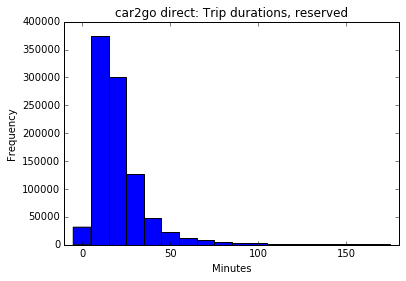

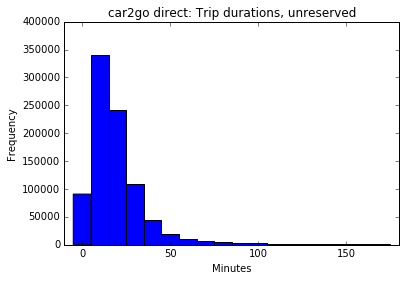

In [12]:
# Histogram of trip durations, with reservations vs without reservations
data = []
for k in cartimelinesdiff:
    for i, j in zip(cartimelinesdiff[k], cartimelinesopstatebefore[k]):
        if j == 2:
            data.append(i)
data = np.divide(np.asarray(data), 60)
plt.hist(data, bins=list(range(0-5,180,10)))
plt.ylabel('Frequency')
plt.xlabel('Minutes')
plt.title('car2go direct: Trip durations, reserved')
plt.ylim((0, 400000))
plt.xlim((-10,180))
plt.show()

data = []
for k in cartimelinesdiff:
    for i, j in zip(cartimelinesdiff[k], cartimelinesopstatebefore[k]):
        if j == 1:
            data.append(i)
data = np.divide(np.asarray(data), 60)
plt.hist(data, bins=list(range(0-5,180,10)))
plt.ylabel('Frequency')
plt.xlabel('Minutes')
plt.title('car2go direct: Trip durations, unreserved')
plt.ylim((0, 400000))
plt.xlim((-10,180))
plt.show()

Apparently, very short trips (<10 min) are 3 times more likely to be not reserved, while longer trips are more likely to be reserved.

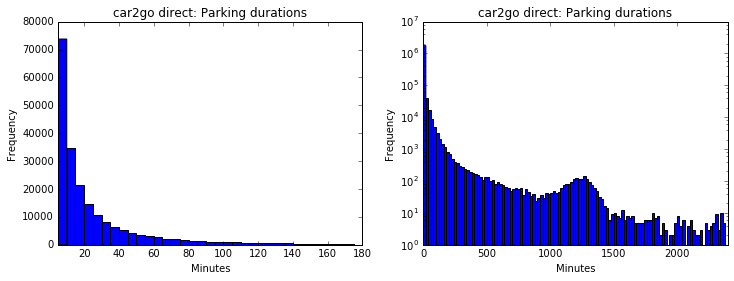

In [59]:
# parking statistics
plt.figure(figsize=(12,4))

plt.subplot(1, 2, 1)
diffs = [cartimelinesparking[k] for k in cartimelinesparking]
data = np.hstack(diffs)
data = np.divide(np.asarray(data), 60)
plt.hist(data, bins=list(range(5,180,5)))
plt.ylabel('Frequency')
plt.xlabel('Minutes')
plt.title('car2go direct: Parking durations')
plt.xlim((5,180))

plt.subplot(1, 2, 2)
diffs = [cartimelinesparking[k] for k in cartimelinesparking]
data = np.hstack(diffs)
data = np.divide(np.asarray(data), 60)
plt.hist(data, bins=list(range(0,2400,20)))
plt.ylabel('Frequency')
plt.xlabel('Minutes')
plt.title('car2go direct: Parking durations')
plt.yscale('log')
plt.xlim((0,2400))

plt.show()

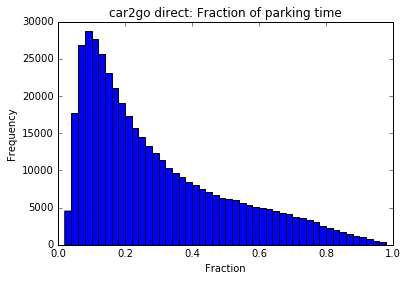

In [60]:
# distribution of fraction of parked time
data1 = [cartimelinesparking[k] for k in cartimelinesparking]
data1 = np.hstack(data1)
data2 = [cartimelinesdiff[k] for k in cartimelinesdiff]
data2 = np.hstack(data2)
data = np.divide(data1, data2)
plt.hist(data, bins=list(np.arange(0.02,1,0.02)))
#plt.hist(data)

plt.ylabel('Frequency')
plt.xlabel('Fraction')
plt.title('car2go direct: Fraction of parking time')

plt.show()



### Simulate crawling of the direct data, and compare results

In [5]:
# load data
cityname = 'Berlin'
cartimelinesinfo = importcartimelines(pathdataoutlocal+'car2go_direct2014_'+cityname+'_cartimelines.txt')
cartimelines = cartimelinesinfo['cartimelines']
cartimelinesid = cartimelinesinfo['cartimelinesid']
cartimelinesdiff = cartimelinesinfo['cartimelinesdiff']
cartimelinesopstateafter = cartimelinesinfo['cartimelinesopstateafter']
cartimelinesopstatebefore = cartimelinesinfo['cartimelinesopstatebefore']
cartimelinesloc = cartimelinesinfo['cartimelinesloc']
cartimelinesparking = cartimelinesinfo['cartimelinesparking']
cardailymovedurations = cartimelinesinfo['cardailymovedurations']

In [ ]:
# simulate crawling every 10 or 5 minutes, save result as simulated crawl
# on hold, since not clear if we really need this

## Fleet or city size versus daily move duration

In [11]:
citynames = ['Berlin', 'Düsseldorf', 'Hamburg', 'Köln', 'München', 'Stuttgart', 'Ulm', 'Wien']

bar = pyprind.ProgBar(len(citynames), bar_char='█', update_interval=1)
cityinfo = dict.fromkeys(citynames) # cannot initialize with sub-dict because mutable: http://stackoverflow.com/questions/2241891/how-to-initialize-a-dict-with-keys-from-a-list-and-empty-value-in-python#comment25131847_2241904
for cityname in citynames:
    cityinfo[cityname] = dict()
    bar.update(item_id = cityname)
    cartimelinesinfo = importcartimelines(pathdataoutlocal+'car2go_direct2014_'+cityname+'_cartimelines.txt')
    cartimelinesid = cartimelinesinfo['cartimelinesid']
    cityinfo[cityname]['fleetsize'] = file_len(pathdataoutlocal+'car2go_direct2014_'+cityname+'_cartimelinesid.txt')
    data = [cartimelinesinfo['cardailymovedurations'][k] for k in cartimelinesinfo['cardailymovedurations']]
    data = list(itertools.chain(*data))
    data = np.divide(np.asarray(data), 60)
    data = data[data>=0] # do not consider the -1 values
    cityinfo[cityname]['dailymovedurationmean'] = np.mean(data)
    

0%    100%
[████████] | ETA: 00:00:00 | Item ID: Wien
Total time elapsed: 00:00:52


In [12]:
# Data from latest UNData
cityinfo['Berlin']['popdensity'] = 3944
cityinfo['Düsseldorf']['popdensity'] = 2800
cityinfo['Hamburg']['popdensity'] = 2260
cityinfo['Köln']['popdensity'] = 2528
cityinfo['München']['popdensity'] = 4700
cityinfo['Stuttgart']['popdensity'] = 2884
cityinfo['Ulm']['popdensity'] = 1000
cityinfo['Wien']['popdensity'] = 4002

cityinfo['Berlin']['pop'] = 3502
cityinfo['Düsseldorf']['pop'] = 594
cityinfo['Hamburg']['pop'] = 1734
cityinfo['Köln']['pop'] = 1024
cityinfo['München']['pop'] = 1388
cityinfo['Stuttgart']['pop'] = 598
cityinfo['Ulm']['pop'] = 118
cityinfo['Wien']['pop'] = 1741


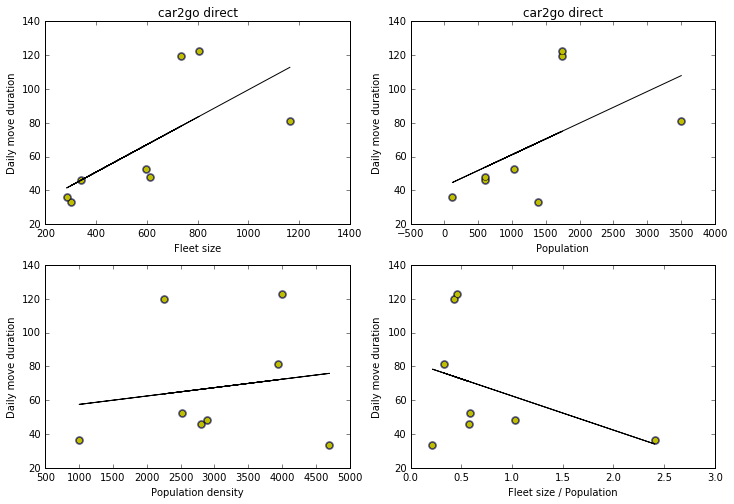

In [13]:
plt.figure(figsize=(12,8))

plt.subplot(2, 2, 1)
x = [cityinfo[c]['fleetsize'] for c in citynames]
y = [cityinfo[c]['dailymovedurationmean'] for c in citynames]
fit = np.polyfit(x,y,1)
fit_fn = np.poly1d(fit) 
plt.plot(x,y, 'yo', x, fit_fn(x), '-k')
plt.scatter(x, y, s = 60, alpha=0.5)
plt.xlabel('Fleet size')
plt.ylabel('Daily move duration')
plt.title('car2go direct')

plt.subplot(2, 2, 2)
x = [cityinfo[c]['pop'] for c in citynames]
y = [cityinfo[c]['dailymovedurationmean'] for c in citynames]
fit = np.polyfit(x,y,1)
fit_fn = np.poly1d(fit) 
plt.plot(x,y, 'yo', x, fit_fn(x), '-k')
plt.scatter(x, y, s = 60, alpha=0.5)
plt.xlabel('Population')
plt.ylabel('Daily move duration')
plt.title('car2go direct')

plt.subplot(2, 2, 3)
x = [cityinfo[c]['popdensity'] for c in citynames]
y = [cityinfo[c]['dailymovedurationmean'] for c in citynames]
fit = np.polyfit(x,y,1)
fit_fn = np.poly1d(fit) 
plt.plot(x,y, 'yo', x, fit_fn(x), '-k')
plt.scatter(x, y, s = 60, alpha=0.5)
plt.xlabel('Population density')
plt.ylabel('Daily move duration')

plt.subplot(2, 2, 4)
x = [np.divide(cityinfo[c]['fleetsize'], cityinfo[c]['pop']) for c in citynames]
y = [cityinfo[c]['dailymovedurationmean'] for c in citynames]
fit = np.polyfit(x,y,1)
fit_fn = np.poly1d(fit) 
plt.plot(x,y, 'yo', x, fit_fn(x), '-k')
plt.scatter(x, y, s = 60, alpha=0.5)
plt.xlabel('Fleet size / Population')
plt.ylabel('Daily move duration')

plt.show()



1st row: Fleet size and daily move duration (DMD) correlate well, also city population and DMD.  
2nd row: Normalized measures (population density, fleet size/population) show no clear effects.